In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
bcw_train = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_train.csv'))
bcw_test = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_test.csv'))
model_metrics = pd.read_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'model_metrics.csv'))

In [ ]:
def decision_boudary(model, min_vals, max_vals, num_features, feature_ids=[0,1]):
    """ Calcula las clasificaciones para una malla regular en dos de las dimensiones de
    entrada del modelo.

    - Argumentos:
      model :  modelo de ML previamente entrenado.
      min_vals : array o lista 2D con los valores mínimos de la malla regular.
      max_vals : array o lista 2D con los valores máximos de la malla regular.
      num_features : número de variables de entrada totales del modelo (aunque representemos solo 2
              el modelo puede tener muchas más).
      feature_ids : índices de las variables que vamos usar en la malla regular.
    """
    # Primero generamos una malla de puntos que cubra el espacio de búsqueda en el
    # cuadrado  definido por min_vals y max_vals.
    ranges = [np.arange(min_v-.1, max_v+.1, 0.05) for min_v, max_v in zip(min_vals, max_vals)]
    xx, yy = np.meshgrid(*ranges)

    # Solo nos interesan las 2 primeras variables, rellenamos con ceros el resto.
    X = np.zeros([xx.ravel().shape[0], num_features])
    X[:, feature_ids[0]] = xx.ravel()
    X[:, feature_ids[1]] = yy.ravel()

    # Evaluamos cada punto de la malla en el modelo árbol de decisión. De esta
    # manera, tenemos una aproximación razonable de la decisión que tomaría nuestro
    # modelo en cada punto del espacio de búsqueda.
    zz = model.predict(X).reshape(xx.shape)
    return xx, yy, zz

# Training the decision tree

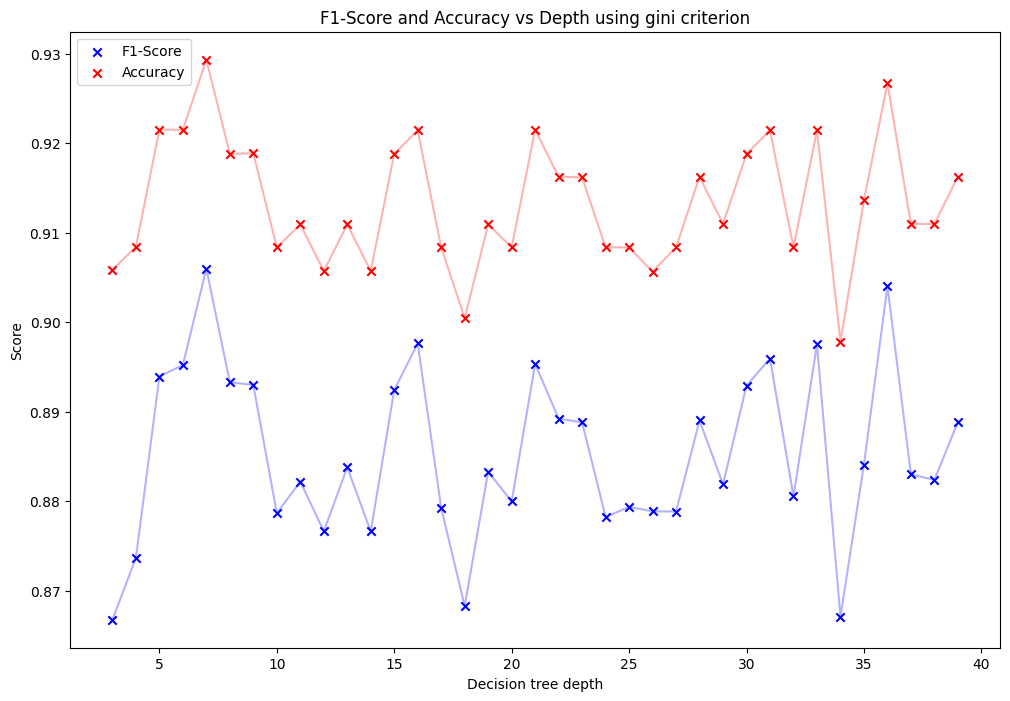

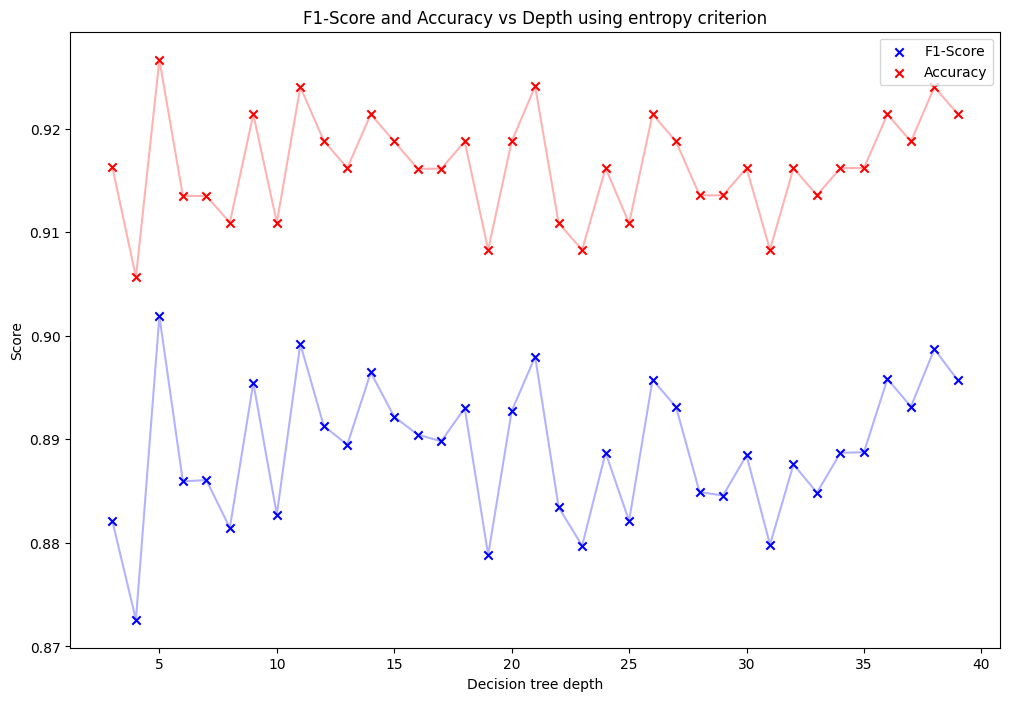

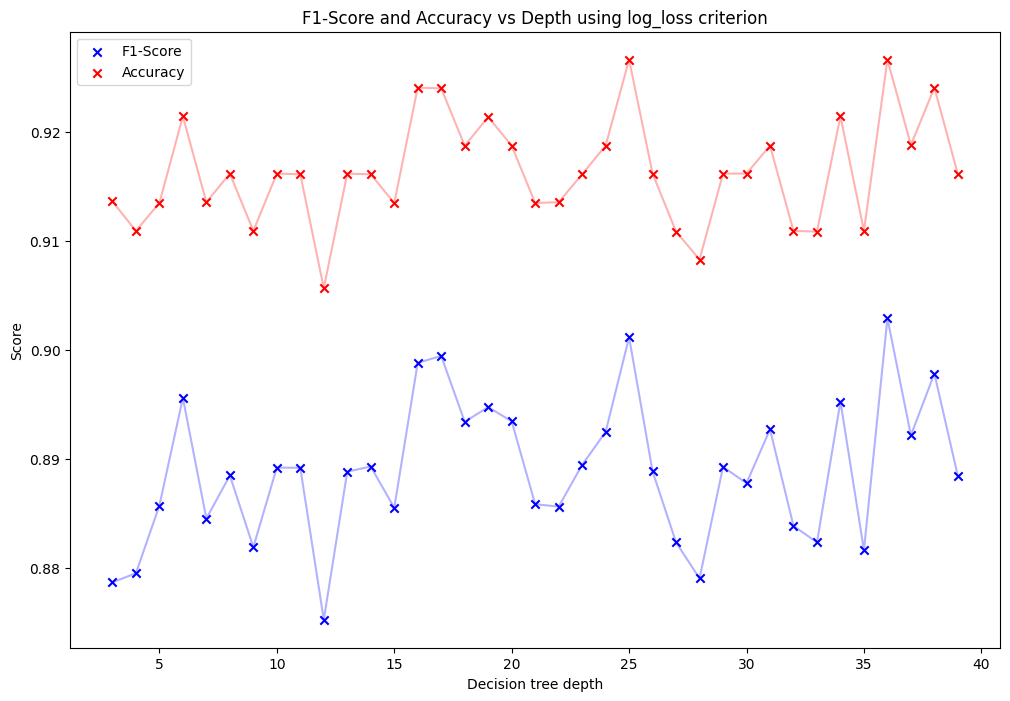

In [ ]:
# Import CV related libraries
from sklearn.model_selection import StratifiedKFold
# Import performance related libraries
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, RocCurveDisplay)

from sklearn.tree import DecisionTreeClassifier

scv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X, y = bcw_train.drop('target', axis=1), bcw_train['target']
criteria = ['gini', 'entropy', 'log_loss']
criteria_metrics = pd.DataFrame(columns=criteria, index=['Accuracy', 'F1-Score'])

for criterion in criteria:
    fig, ax = plt.subplots(figsize=(12, 8))

    average_metrics = []  # Reset for each criterion
    avg_f1_values = []
    avg_accuracy_values = []

    for depth in np.arange(3, 40):
        fold_metrics = {'F1-Score': [], 'Accuracy': []}

        for i, (train, validation) in enumerate(scv.split(X, y)):
            dtree = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
            dtree.fit(X.iloc[train], y.iloc[train])

            y_pred = dtree.predict(X.iloc[validation])
            fold_metrics['F1-Score'].append(f1_score(y.iloc[validation], y_pred))
            fold_metrics['Accuracy'].append(accuracy_score(y.iloc[validation], y_pred))

        # Calculate average metrics for this k value
        avg_f1 = np.mean(fold_metrics['F1-Score'])
        avg_accuracy = np.mean(fold_metrics['Accuracy'])
        # These two lists save the data to plot the line
        avg_f1_values.append(avg_f1)
        avg_accuracy_values.append(avg_accuracy)
        # Plotting the average F1-Score and Accuracy for this k value
        ax.scatter(depth, avg_f1, color='b', marker='x')
        ax.scatter(depth, avg_accuracy, color='r', marker='x')
        # Save the neighbours and the fold score for that neightbour
        average_metrics.append((depth, avg_f1, avg_accuracy))
    ax.plot(range(3, 40), avg_f1_values, color='b', alpha=0.3)
    ax.plot(range(3, 40), avg_accuracy_values, color='r', alpha=0.3)

    # Find the maximum values and their corresponding depth values
    max_f1 = max(avg_f1_values)
    depth_max_f1 = avg_f1_values.index(max_f1) + 3
    max_accuracy = max(avg_accuracy_values)
    depth_max_accuracy = avg_accuracy_values.index(max_accuracy) + 3
    criteria_metrics[criterion] = [(max_accuracy.round(3), depth_max_accuracy), (max_f1.round(3), depth_max_f1)]
    #Plot
    ax.set_xlabel('Decision tree depth')
    ax.set_ylabel('Score')
    ax.set_title(f'F1-Score and Accuracy vs Depth using {criterion} criterion')
    ax.legend(['F1-Score', 'Accuracy'])
    plt.show()
    criteria_metrics

In [ ]:
criteria_metrics

,gini,entropy,log_loss
Accuracy,"(0.929, 7)","(0.927, 5)","(0.927, 25)"
F1-Score,"(0.906, 7)","(0.902, 5)","(0.903, 36)"


# Test

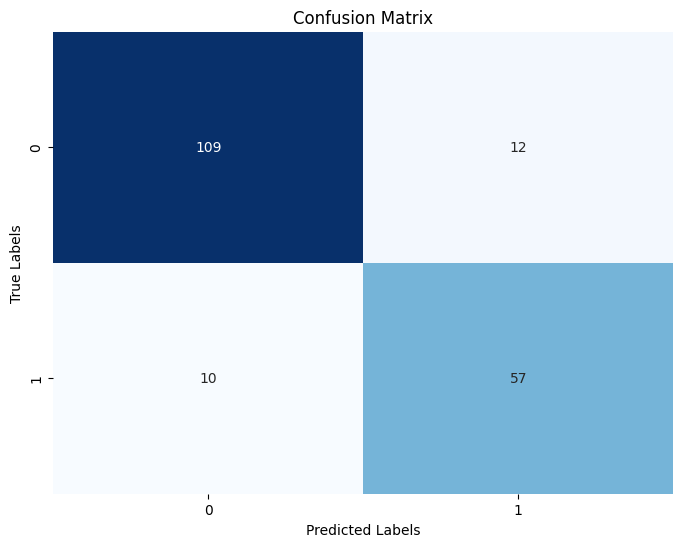

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &  Recall &  F1-Score \\
\midrule
0 &     0.883 &      0.883 &   0.851 &     0.838 \\
\bottomrule
\end{tabular}



In [ ]:
# Initialize the Decision tree classifier and fit
X_train, y_train = bcw_train.drop('target', axis=1), bcw_train['target']

dtree_best = DecisionTreeClassifier(criterion='entropy', max_depth=8)
dtree_best.fit(X_train, y_train)

X_test, y_test = bcw_test.drop('target', axis=1), bcw_test['target']
y_pred = dtree_best.predict(X_test)

final_metrics = pd.DataFrame(data={'Accuracy': accuracy_score(y_test, y_pred),
                                   'Precision': accuracy_score(y_test, y_pred),
                                   'Recall': recall_score(y_test, y_pred),
                                   'F1-Score': f1_score(y_test, y_pred)}, index=[0])
final_metrics['Model'] = 'DTREE'
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(final_metrics.iloc[:, :-1].to_latex(index=True,
                  float_format="{:.3f}".format,
))

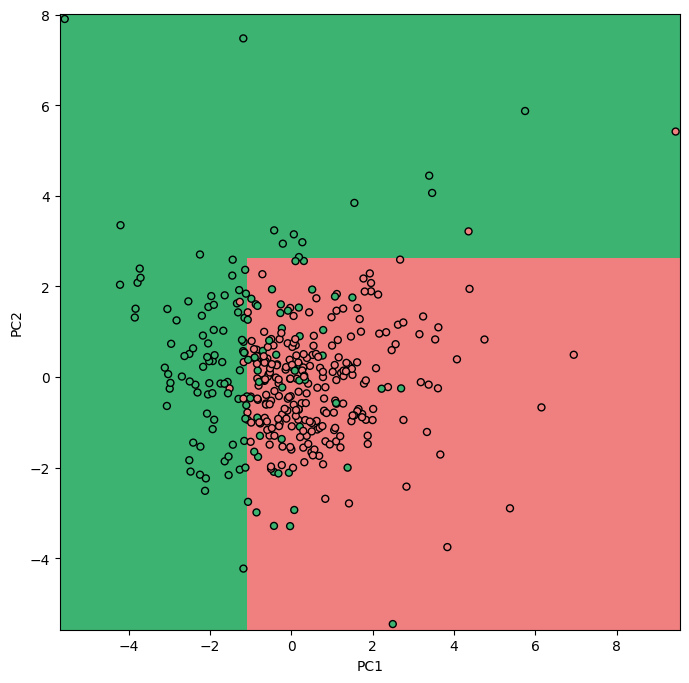

In [ ]:
pcs = [1, 2]

# Calculamos la frontera de decisión.
xx, yy, zz = decision_boudary(dtree_best, X_train.min(0)[pcs], X_train.max(0)[pcs], \
                              X_train.shape[1], feature_ids=pcs)

# Pintamos la frontera de decisión
cmap = colors.ListedColormap(['lightcoral', 'mediumseagreen'])
plt.figure(figsize=(8,8))
plt.pcolormesh(xx, yy, zz.astype(float), cmap=cmap)
clrs = [ ('lightcoral', 'mediumseagreen')[int(y_i)] for y_i in y_train]
plt.scatter(X_train.values[:, pcs[0]], X_train.values[:, pcs[1]], ec='k', color=clrs, s=25)
plt.xlabel(f'PC{pcs[0]}')
plt.ylabel(f'PC{pcs[1]}')
plt.show()

In [ ]:
final_metrics = pd.DataFrame(data={'Accuracy': 0.904,
                                   'Precision': 0.904,
                                   'Recall': 0.881,
                                   'F1-Score': 0.868}, index=[0])
final_metrics['Model'] = 'DTREE'
model_metrics = pd.concat([model_metrics, final_metrics], ignore_index=True)

In [ ]:
# model_metrics.to_csv(os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'model_metrics.csv'), index=False)

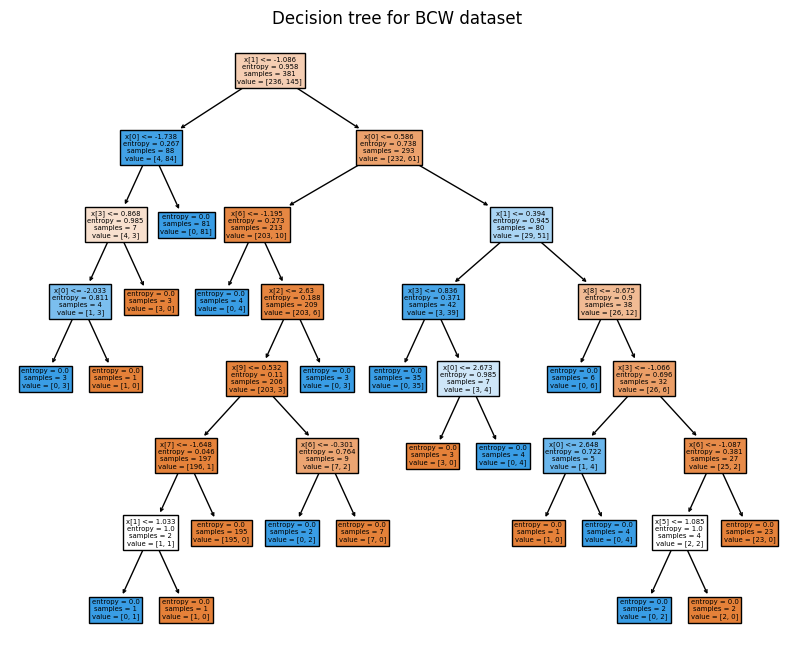

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,8))
plot_tree(dtree_best, filled=True)
plt.title("Decision tree for BCW dataset")
plt.show()

# Decision surface omg

In [ ]:
def plot_decision_surface(clf, X, y, ax):

    """
    Plot the decision surface of a classifier (clf) trained on features (X) and labels (y).
    Parameters:
        clf: Trained classifier
        X: Feature matrix
        y: Label vector
        ax: Matplotlib axis object to plot on
    """

    # Create meshgrid for feature space
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Make predictions on meshgrid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.8)

    # Plot training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, linewidth=1)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)


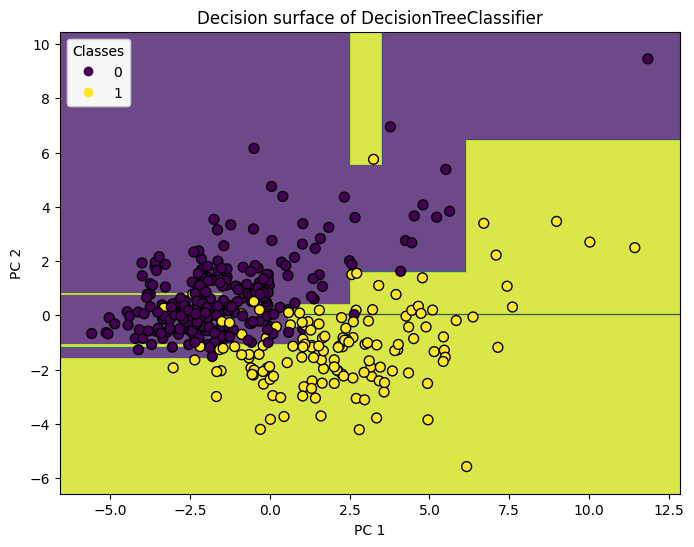

In [ ]:
# Extract selected features and target from training and test datasets
X_train_selected = bcw_train[['PC 1', 'PC 2']]
y_train = bcw_train['target']
X_test_selected = bcw_test[['PC 1', 'PC 2']]
y_test = bcw_test['target']

# Initialize and train decision tree with the specified parameters
dtree_best = DecisionTreeClassifier(criterion='entropy', max_depth=8)
dtree_best.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = dtree_best.predict(X_test_selected)

# Prepare the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title(f"Decision surface of DecisionTreeClassifier")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
# Plot decision surface
plot_decision_surface(dtree_best, X_train.to_numpy(), y_train.to_numpy(), ax)

plt.show()

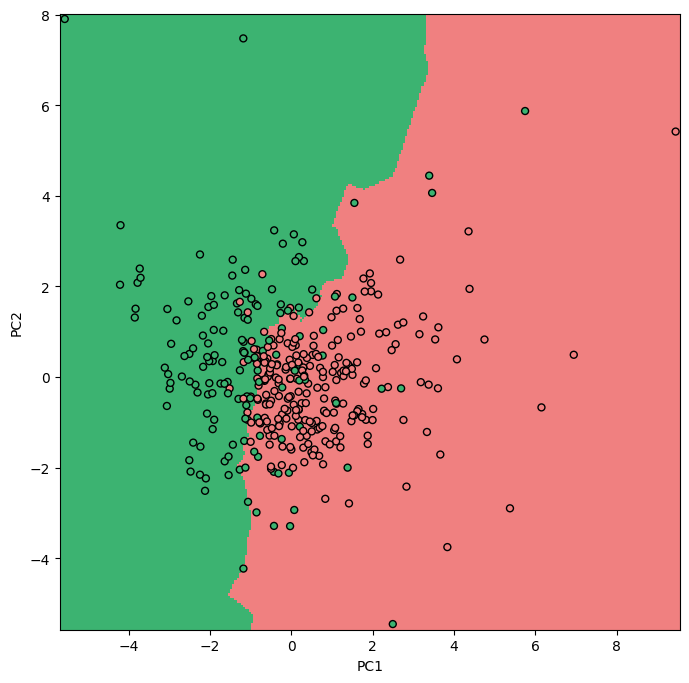

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Extract selected features and target from training and test datasets
X_train, y_train = bcw_train.drop('target', axis=1), bcw_train['target']
X_test, y_test = bcw_test.drop('target', axis=1), bcw_test['target']

# Initialize and train decision tree with the specified parameters
knn_best = KNeighborsClassifier(n_neighbors=8)
knn_best.fit(X_train, y_train)

pcs = [1, 2]

# Calculamos la frontera de decisión.
xx, yy, zz = decision_boudary(knn_best, X_train.min(0)[pcs], X_train.max(0)[pcs], \
                              X_train.shape[1], feature_ids=pcs)

# Pintamos la frontera de decisión
cmap = colors.ListedColormap(['lightcoral', 'mediumseagreen'])
plt.figure(figsize=(8,8))
plt.pcolormesh(xx, yy, zz.astype(float), cmap=cmap)
clrs = [ ('lightcoral', 'mediumseagreen')[int(y_i)] for y_i in y_train]
plt.scatter(X_train.values[:, pcs[0]], X_train.values[:, pcs[1]], ec='k', color=clrs, s=25)
plt.xlabel(f'PC{pcs[0]}')
plt.ylabel(f'PC{pcs[1]}')
plt.show()